# **Image classification using CNNs in Keras**

## **Learning Outcomes:**



* Pre-processing of image data.
* Visualization of images.
* Building CNN.
* Evaluate the Model.
* The motive of the project is to make the learners capable to handle images/image classification problems, during this
process you should also be capable to handle real image files, not just limited to a numpy array of image pixels.



### **Data Description:**
You are provided with a dataset of images of plant seedlings at various stages of grown. Each image has a filename that is its
unique id. The dataset comprises 12 plant species.

The goal of the project is to create a classifier capable of determining a plant's species from a photo.

### **Context:**

**Can you differentiate a weed from a crop seedling?**

The ability to do so effectively can mean better crop yields and better stewardship of the environment.
The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has
recently released a dataset containing images of unique plants belonging to 12 species at several growth stages

### **Dataset**


*   labels.csv : labels 
*   images.npy : The images of plant seedlings



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Library Imports



In [4]:
import pandas as pd
import numpy as np

import cv2
from google.colab.patches import cv2_imshow
from glob import glob
from matplotlib import pyplot as plt
import itertools

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,InputLayer,BatchNormalization, Flatten, Conv2D, MaxPool2D,Activation,GlobalMaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop,SGD 
from keras.utils.np_utils import to_categorical  
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

from random import randint
import random


#### Loading the datasets & Summary

In [20]:

labels = pd.read_csv("/content/Labels.csv" )

In [6]:
labels.head()


,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


In [21]:
images = np.load('/content/images.npy' )

In [10]:
images

array([[[[ 35,  52,  78],
         [ 36,  49,  76],
         [ 31,  45,  69],
         ...,
         [ 78,  95, 114],
         [ 76,  93, 110],
         [ 80,  95, 109]],

        [[ 33,  46,  68],
         [ 37,  50,  73],
         [ 48,  65,  83],
         ...,
         [ 81,  96, 113],
         [ 74,  89, 105],
         [ 83,  95, 109]],

        [[ 34,  50,  68],
         [ 35,  52,  72],
         [ 70,  85, 101],
         ...,
         [ 83,  97, 112],
         [ 79,  94, 108],
         [ 79,  94, 107]],

        ...,

        [[ 35,  50,  69],
         [ 42,  57,  73],
         [ 42,  57,  72],
         ...,
         [ 60,  76,  92],
         [ 67,  81,  97],
         [ 64,  77,  95]],

        [[ 36,  52,  67],
         [ 48,  63,  78],
         [ 41,  57,  73],
         ...,
         [ 44,  66,  83],
         [ 58,  76,  91],
         [ 57,  74,  90]],

        [[ 44,  58,  70],
         [ 43,  57,  73],
         [ 40,  55,  72],
         ...,
         [ 41,  70,  92],
        

In [13]:
images.shape

(4750, 128, 128, 3)

In [15]:
labels.shape

(4750, 1)

There are 4750 128x128x3 images and so 4750 labels.

In [18]:
print ("Number of Images for each Category are: ")
labels.value_counts()

Number of Images for each Category are: 


Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

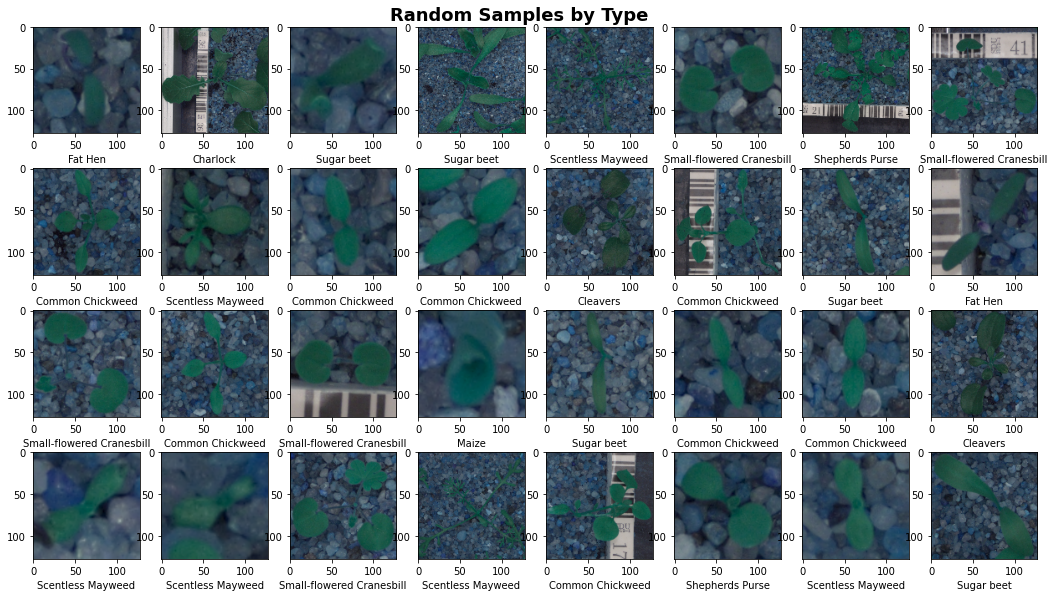

In [70]:
#Visualizing the Images by Label randomly
random.seed(1)
f, axarr = plt.subplots(4,8,figsize=(18,10))
f.suptitle('Random Samples by Type', fontsize = 18, y =.9, horizontalalignment = 'center', weight = 'bold')

for i in range(4):
  for j in range(8):
    randomindex = randint(0, 4000)
    axarr[i,j].imshow(images[randomindex])
    axarr[i,j].set(xlabel= labels.iloc[randomindex,0])
plt.show()

### **Exploratory Data Analysis on the images**

**Mean images of each class**

In [140]:
def find_mean_img(full_mat, title):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    # mean_img = mean_img.reshape((384,384))
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

In [40]:
print(images[0].shape)

(128, 128, 3)


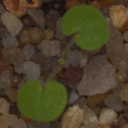

Label    Small-flowered Cranesbill
Name: 5, dtype: object

In [65]:
cv2_imshow(images[5])
labels.iloc[5]

In [83]:
CATEGORIES = labels['Label'].unique()

In [119]:
dic_labelled_img = dict.fromkeys(CATEGORIES) ## OR d = {key:[] for key in CATEGORIES}
dic_labelled_img

{'Black-grass': None,
 'Charlock': None,
 'Cleavers': None,
 'Common Chickweed': None,
 'Common wheat': None,
 'Fat Hen': None,
 'Loose Silky-bent': None,
 'Maize': None,
 'Scentless Mayweed': None,
 'Shepherds Purse': None,
 'Small-flowered Cranesbill': None,
 'Sugar beet': None}

In [120]:
for key in dic_labelled_img:
  print(key)

Small-flowered Cranesbill
Fat Hen
Shepherds Purse
Common wheat
Common Chickweed
Charlock
Cleavers
Scentless Mayweed
Sugar beet
Maize
Black-grass
Loose Silky-bent


Assosciating labels to the images with help of dictionary:

In [121]:
# for key in d:
#   for i in range (0,len(labels)):
#     if (labels.loc[[i]].Label).equals(key):
#       print(d[key])
#       d[key].append(images[i])

for i in range (0,len(labels)):
  dic_labelled_img[(labels.loc[i].Label)] = images[i]

In [118]:
# images[4].shape
dic_labelled_img

{'Black-grass': None,
 'Charlock': None,
 'Cleavers': None,
 'Common Chickweed': None,
 'Common wheat': None,
 'Fat Hen': None,
 'Loose Silky-bent': None,
 'Maize': None,
 'Scentless Mayweed': None,
 'Shepherds Purse': None,
 'Small-flowered Cranesbill': array([[[ 49,  48,  57],
         [ 47,  48,  58],
         [ 48,  50,  56],
         ...,
         [ 48,  47,  54],
         [ 73,  69,  82],
         [ 73,  72,  82]],
 
        [[ 48,  49,  59],
         [ 48,  54,  58],
         [ 72,  70,  75],
         ...,
         [ 46,  48,  54],
         [ 63,  64,  67],
         [ 69,  66,  75]],
 
        [[ 48,  49,  60],
         [ 60,  65,  67],
         [100, 102, 106],
         ...,
         [ 36,  39,  47],
         [ 43,  44,  52],
         [ 72,  69,  80]],
 
        ...,
 
        [[ 59,  55,  60],
         [ 60,  57,  61],
         [ 62,  59,  61],
         ...,
         [ 38,  68,  86],
         [ 50,  73,  91],
         [ 39,  60,  81]],
 
        [[138, 135, 138],
         [169

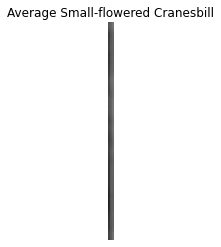

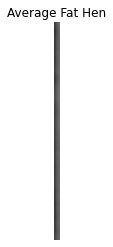

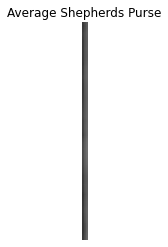

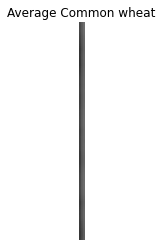

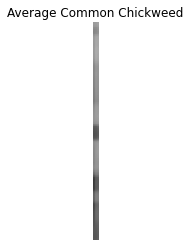

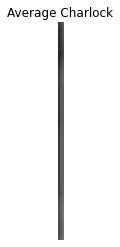

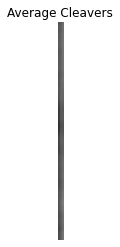

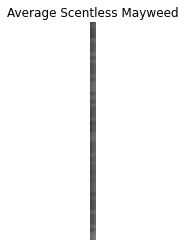

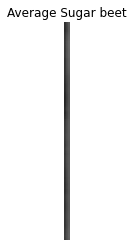

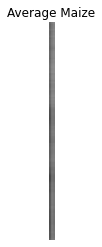

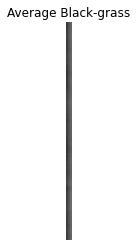

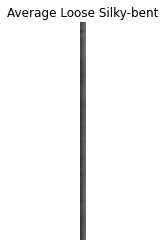

In [141]:
for key in dic_labelled_img:
  #find_mean_img()
  find_mean_img(dic_labelled_img[key],key)

IT doesnot show clear details.

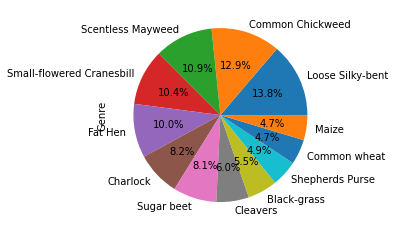

In [146]:
labels['Label'].value_counts().plot(kind='pie', label='Genre', autopct='%.01f%%')
# df.genres.str.get_dummies().sum().plot.pie(label='Genre', autopct='%1.0f%%')


We can see Common chick weed makes up most of the samples ar 12.9%

#### Data Pre-processing

* Gaussian Blur
* Normalization

Text(0.5, 1.0, 'Blurred')

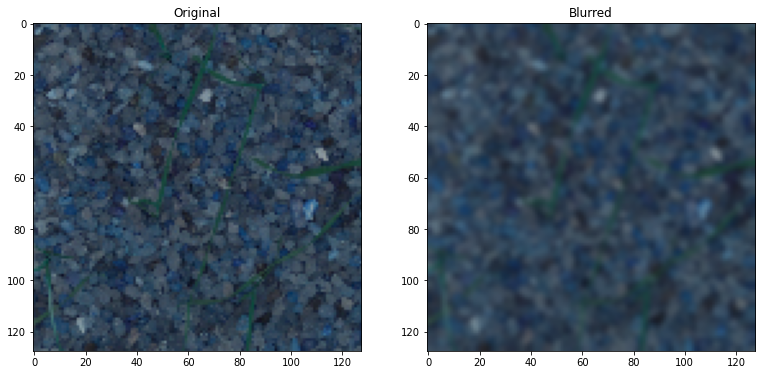

In [22]:
preprocessed_images = [] 

   # Gaussian Blurring
for i in images:
 
    blurred = cv2.GaussianBlur(i,(5,5),0)
    preprocessed_images.append(blurred)  

plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1); plt.imshow(i); plt.title("Original")
plt.subplot(1, 3, 2); plt.imshow(blurred);plt.title("Blurred")



In [23]:
# Normalizing
preprocesssedimg_new = np.asarray(preprocessed_images)
preprocesssedimg_new = preprocesssedimg_new/255

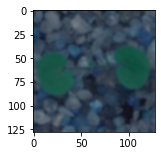

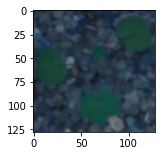

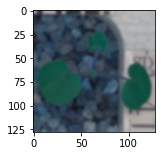

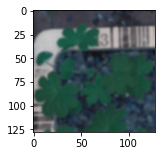

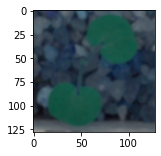

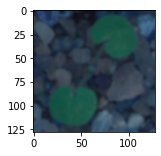

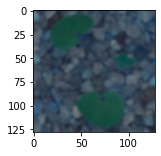

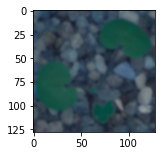

In [176]:
# plt.title("Normalized Images")
f.suptitle('Normalized Images', fontsize = 18, y =.9, horizontalalignment = 'center', weight = 'bold')
for i in range(8):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 4, i + 1)
    plt.imshow(preprocesssedimg_new[i])

#### Make Data Compatible

Convert labels from digits to one hot vector. - Check the shape of the data. Reshape the data into shapes compatible with Keras models, if already not compatible.

Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
12


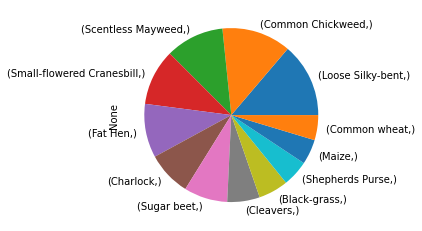

In [24]:
##labels to one hot vectors

enc = preprocessing.LabelEncoder()
enc.fit(labels.Label)
print('Classes'+str(enc.classes_))

encodedlabels = enc.transform(labels.Label) 
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print(str(classes))
labels.value_counts().plot(kind='pie')

In [188]:
print(clearalllabels) ##encoded label to be used for training

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [189]:
print(clearalllabels[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


Splitting to Train and Test

In [25]:
X_train,X_test,y_train,y_test = train_test_split(preprocesssedimg_new,clearalllabels,test_size=0.3,random_state=38,stratify=clearalllabels)

In [200]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3325, 128, 128, 3)
(3325, 12)
(1425, 128, 128, 3)
(1425, 12)


In [201]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [26]:
# Reshape data into shapes compatible with Keras models.

X_train = X_train.reshape(X_train.shape[0], 128, 128, 3)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 3)

In [203]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3325, 128, 128, 3)
(3325, 12)
(1425, 128, 128, 3)
(1425, 12)


Since the shape post reshaping remained same to the original, the data is already compatible.



In [33]:
##Splitting data to Validation Set
from sklearn.model_selection import train_test_split
X_test_new, X_val, y_test_new, y_val = train_test_split(X_test,y_test,test_size=0.5,random_state=38,stratify=y_test)

In [209]:
print(X_test.shape)
print(X_val.shape)

(1425, 128, 128, 3)
(713, 128, 128, 3)


In [210]:
print(X_val.shape)
print(y_val.shape)
print(X_test_new.shape)
print(y_test_new.shape)

(713, 128, 128, 3)
(713, 12)
(712, 128, 128, 3)
(712, 12)


#### Model Building

**CNN with dropout:**
DETAILS:
2 convolution layers ( filters=64 / 128 , kernel_size=(3, 3;activation='relu');
MaxPool2D((2, 2);
Dropout(0.25);
Flatten;
2 dense layers (128 / 64, activation='relu');
Dropout(0.25);
loss='categorical_crossentropy', optimizer='adam';



In [28]:
model = Sequential()


model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 115200)           

In [9]:
model = Sequential()


model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0

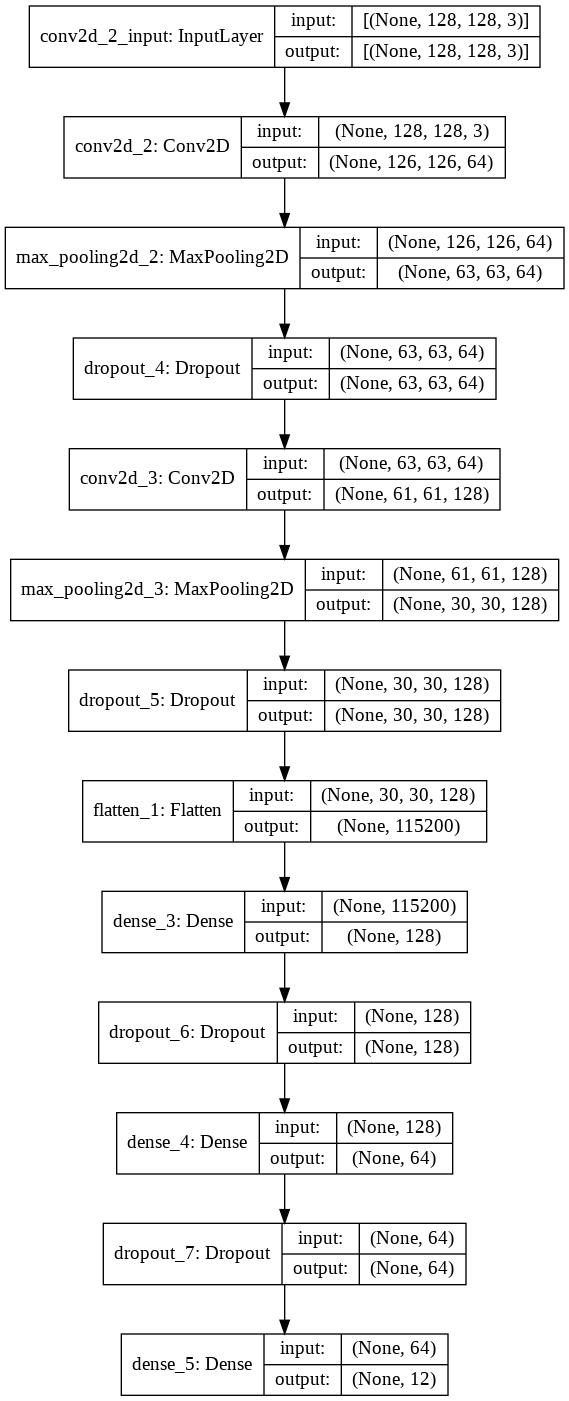

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

#### Model Imporevement & Performmance Check

In [34]:
##fitting model with epoch 40 on validation set to evaluate
history = model.fit(X_train, y_train, epochs = 40,shuffle=True, validation_data = (X_val,y_val),batch_size = 64)
pd.DataFrame(history.history)

Epoch 1/40
52/52 [==============================] - 142s 3s/step - loss: 2.5297 - accuracy: 0.1272 - val_loss: 2.4361 - val_accuracy: 0.2202
Epoch 2/40
52/52 [==============================] - 141s 3s/step - loss: 2.3215 - accuracy: 0.1988 - val_loss: 2.0207 - val_accuracy: 0.2945
Epoch 3/40
52/52 [==============================] - 140s 3s/step - loss: 1.9315 - accuracy: 0.3251 - val_loss: 1.7112 - val_accuracy: 0.3913
Epoch 4/40
52/52 [==============================] - 136s 3s/step - loss: 1.6319 - accuracy: 0.4220 - val_loss: 1.4428 - val_accuracy: 0.5203
Epoch 5/40
52/52 [==============================] - 135s 3s/step - loss: 1.4409 - accuracy: 0.4941 - val_loss: 1.2339 - val_accuracy: 0.5582
Epoch 6/40
52/52 [==============================] - 135s 3s/step - loss: 1.3240 - accuracy: 0.5284 - val_loss: 1.3519 - val_accuracy: 0.5245
Epoch 7/40
52/52 [==============================] - 135s 3s/step - loss: 1.2065 - accuracy: 0.5723 - val_loss: 1.1926 - val_accuracy: 0.5947
Epoch 8/40
52

,loss,accuracy,val_loss,val_accuracy
0,2.529721,0.127218,2.436126,0.220196
1,2.321453,0.198797,2.020669,0.294530
2,1.931515,0.325113,1.711167,0.391304
3,1.631872,0.421955,1.442759,0.520337
4,1.440900,0.494135,1.233858,0.558205
5,1.324023,0.528421,1.351875,0.524544
6,1.206500,0.572331,1.192587,0.594670
7,1.125407,0.602406,1.044935,0.643759
8,1.078557,0.620451,1.014221,0.654979
9,1.043683,0.636692,1.044815,0.638149


The accuracy is improving insignificantly in the earlier epochs.

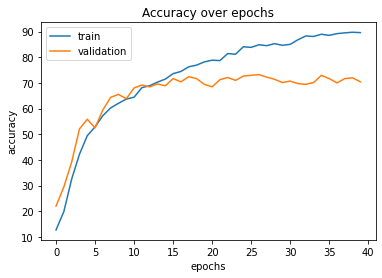

In [35]:
plt.plot(np.array(history.history['accuracy']) * 100)
plt.plot(np.array(history.history['val_accuracy']) * 100)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'])
plt.title('Accuracy over epochs')
plt.show()

In [39]:
scores = model.evaluate(X_test_new, y_test_new)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 6s 282ms/step - loss: 1.3880 - accuracy: 0.6643
Test loss: 1.3880305290222168
Test accuracy: 0.6643258333206177


In [40]:
##COnfusion Matrix for model evaluation

In [41]:

def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Greens):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

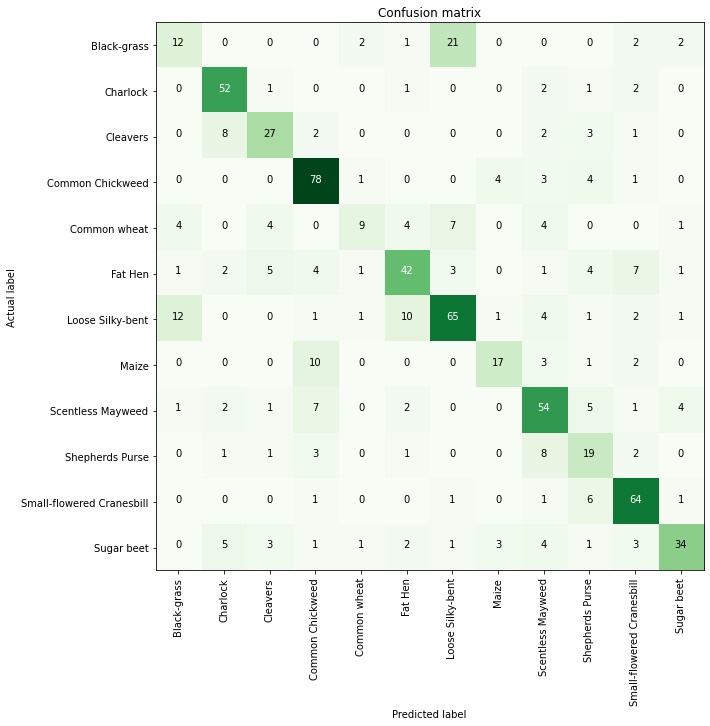

In [44]:

# Predict the values from the test data
y_pred = model.predict(X_test_new)
y_pred_Classes = np.argmax(y_pred, axis = 1) 
trueY = np.argmax(y_test_new, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, y_pred_Classes) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = enc.classes_)

In [45]:

#Final score and accuracy of the model

score, acc = model.evaluate(X_test_new,y_test_new)
score1, acc1 = model.evaluate(X_train,y_train)
print('Test score:', score,'   Test accuracy:', acc)
print('Train score:', score1,'   Train accuracy:',acc1)

104/104 [==============================] - 29s 278ms/step - loss: 0.1047 - accuracy: 0.9777
Test score: 1.3880305290222168    Test accuracy: 0.6643258333206177
Train score: 0.10465596616268158    Train accuracy: 0.9777443408966064


In [48]:
# from sklearn.metrics import precision_recall_fscore_support  

# p=precision_recall_fscore_support(np.array(y_test), y_pred_Classes, average=None,labels=list(np.unique(y_test)))

# print(" Precision is {}\n Recall is {} \n f_beta Score is {}".format(p[0],p[1],p[2]))


Visualize predictions for:
* x_test[2],
* x_test[3], 
* x_test[33], 
* x_test[36], 
* x_test[59].



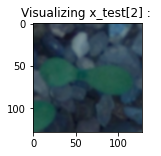

Predicted Label 8
True Label 8


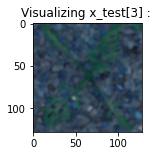

Predicted Label 8
True Label 8


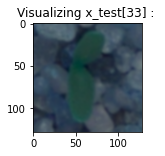

Predicted Label 8
True Label 11


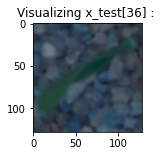

Predicted Label 11
True Label 4


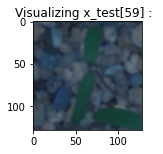

Predicted Label 3
True Label 5


In [53]:
import numpy as np


plt.figure(figsize=(2,2))
plt.imshow(X_test[2],cmap="gray")
plt.title("Visualizing x_test[2] : ")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[2].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[2]))


plt.figure(figsize=(2,2))
plt.imshow(X_test[3],cmap="gray")
plt.title("Visualizing x_test[3] : ")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[3].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[3]))


plt.figure(figsize=(2,2))
plt.imshow(X_test[33],cmap="gray")
plt.title("Visualizing x_test[33] : ")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[33].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[33]))


plt.figure(figsize=(2,2))
plt.imshow(X_test[36],cmap="gray")
plt.title("Visualizing x_test[36] : ")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[36].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[36]))


plt.figure(figsize=(2,2))
plt.imshow(X_test[59],cmap="gray")
plt.suptitle("Visualizing x_test[59] : ")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[59].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[59]))



#### **Conclusion and key takeaways**

* There is scope of improvement. More layers can be added to improve the accuracy, in addition to better noise cancellation.
* The accuracy can also be expected to improved by including hyperparameter tuning to ensure no overfitting.